# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [140]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [141]:
batch_size=32*8*2
epochs=5
learning_rate=1e-3
latent_dim = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print layers, used for debugging
NNprint_ = False
classes=[0,1,2,3,4]
num_classes=len(classes)
file='fashioncvae.torch'

### Import MNIST Dataset

In [142]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

### Import FashionMNIST Dataset

In [143]:
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=False, transform=transforms.ToTensor(),
    download=False)

### Configure Loaders

In [144]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=batch_size,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=batch_size,sampler=stratified_sampler(test.targets,classes))

### Plot examples

In [145]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

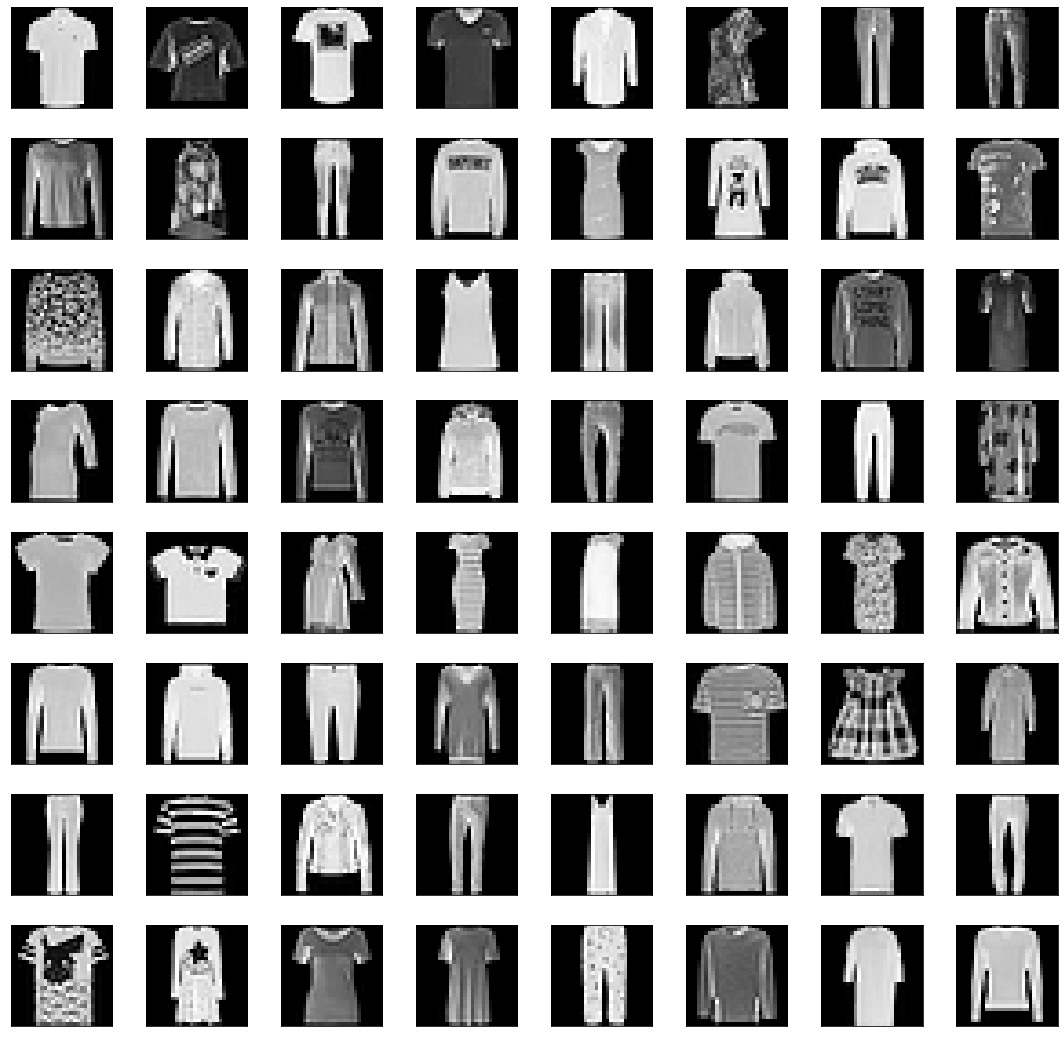

In [146]:
plot_examples()

### Torch auxiliary modules

In [147]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## VAE

In [148]:
#VAE implementation

## CVAE

In [149]:

class CVAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(CVAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    
    
    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def elbo(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self,z):
        return self.decode(z)

In [150]:
image_channels = example_data.size(1)
image_channels

1

In [151]:
model = CVAE(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            recon_images, mu, logvar = model(images.to(device),labels)
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

In [153]:
epochs=50

In [154]:
%%time
##
train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

torch.save(model.state_dict(), file)


Epoch 1 of 50


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Loss: 175.6039
Val Loss: 143.0279
Epoch 2 of 50
Train Loss: 134.5974
Val Loss: 130.3611
Epoch 3 of 50
Train Loss: 125.8040
Val Loss: 124.2007
Epoch 4 of 50
Train Loss: 121.2139
Val Loss: 121.0115
Epoch 5 of 50
Train Loss: 117.9165
Val Loss: 118.1056
Epoch 6 of 50
Train Loss: 115.9698
Val Loss: 116.3629
Epoch 7 of 50
Train Loss: 114.3684
Val Loss: 115.4478
Epoch 8 of 50
Train Loss: 113.4404
Val Loss: 114.5383
Epoch 9 of 50
Train Loss: 113.2253
Val Loss: 113.6298
Epoch 10 of 50
Train Loss: 111.7765
Val Loss: 112.9052
Epoch 11 of 50
Train Loss: 111.3139
Val Loss: 112.6974
Epoch 12 of 50
Train Loss: 110.8969
Val Loss: 112.1839
Epoch 13 of 50
Train Loss: 110.4207
Val Loss: 111.6252
Epoch 14 of 50
Train Loss: 110.1532
Val Loss: 111.5728
Epoch 15 of 50
Train Loss: 109.7522
Val Loss: 111.1493
Epoch 16 of 50
Train Loss: 109.5926
Val Loss: 110.9322
Epoch 17 of 50
Train Loss: 109.3445
Val Loss: 110.7089
Epoch 18 of 50
Train Loss: 109.1577
Val Loss: 110.3713
Epoch 19 of 50
Train Loss: 108.81

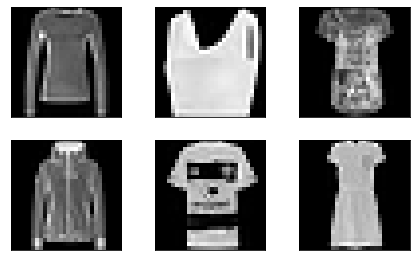

In [210]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,latent_dim)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

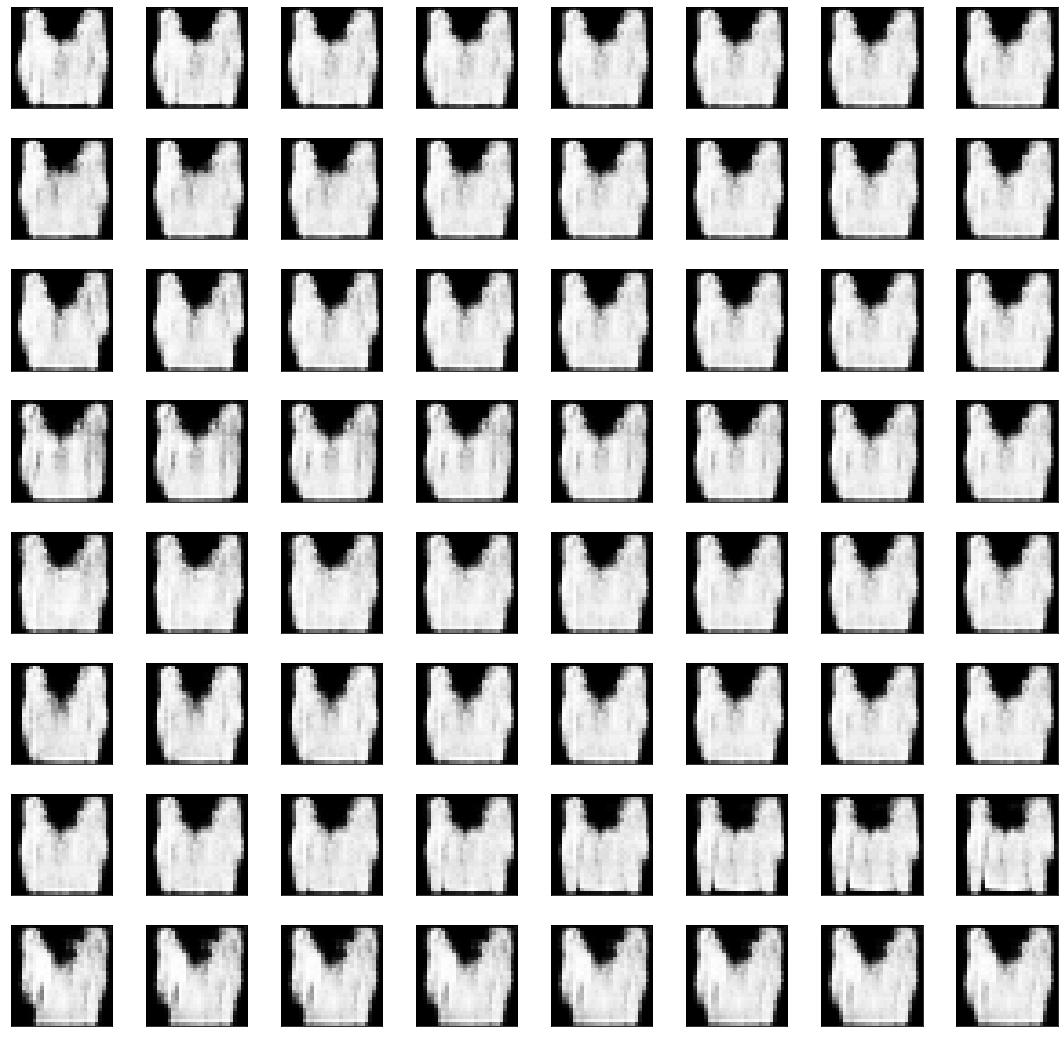

In [214]:
for i in range(test_data.shape[0]):
    test_data[i]=ztest[1]

    
range_=np.linspace(5,-5,int(latent_dim/4))
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

In [216]:

def train_classifier(example_data,example_targets,samples_per_class,classifier):
    ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
    test_data=torch.zeros(64,8)
    label_n=0
    label_counter=0
    labellist=[]
    for i in range(len(classes)):
        labellist.append(np.where(example_targets.cpu().numpy()==i)[0][:samples_per_class].tolist())
    labellist=np.sort(np.array(labellist).flatten())
    mask = np.ones(example_targets.cpu().numpy().shape,dtype=bool) #np.ones_like(a,dtype=bool)
    mask[labellist] = False
    
    trainKNN_out=example_targets[labellist]
    trainKNN_in=ztest[labellist]
    testKNN_out=example_targets[mask]
    testKNN_in=ztest[mask]
    
    classifier.fit(trainKNN_in.cpu().detach().numpy(), trainKNN_out)
    return classifier,testKNN_out,testKNN_in

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
samples_per_class=10
classifier,testKNN_out,testKNN_in=train_classifier(example_data,example_targets,samples_per_class,neigh)

In [218]:
def test_classifier(classifier,testKNN_out,testKNN_in):
    error=0
    for test_n in range(len(testKNN_out)):
        exp,real=classifier.predict([testKNN_in.cpu().detach().numpy()[test_n]])[0],testKNN_out[test_n].numpy()
    #     print(exp,real)
        if exp!=real:
            error+=1
    print(error,test_n,error/test_n)
    
test_classifier(classifier,testKNN_out,testKNN_in)

125 461 0.27114967462039047


In [208]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,8)
for i in range(test_data.shape[1]):
    print('max',ztest[:,i].max())
    print('min',ztest[:,i].min())
    print('mean',ztest[:,i].mean())
    print()

max tensor(4.9978, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-3.7958, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(7.3270, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-3.5233, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.6927, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(4.3903, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-4.3540, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.0502, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(7.6323, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-6.8648, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.8692, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-6.3621, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.9483, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(6.1063, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-7.9190